In [1]:
from dependencies import *

_ColormakerRegistry()

# Analysis

## Data read

Read data (and wrap periodic images)

In [159]:
first_file_num, last_file_num = 1, 25
prefix = "output"
file_nums = [2,4,5,7,11,14,15,16,17,20,21,22, 24,25]
# file_nums = range(first_file_num, last_file_num + 1)
data = [gen.read_gen("../" + prefix + str(i) + ".gen") for i in file_nums]
for i in data:
    i.wrap()
#exclude errored runs
# error_list = [6, 10, 12, 13, 21]

FileNotFoundError: [Errno 2] No such file or directory: '../output2.gen'

Show atoms, save image

In [ ]:
show_atoms_grid(data)
    
# fig.savefig("allconfigs.png")

## RDF

In [ ]:
datadir = "../bomb/" #bare bombardment, v0.13 = 35.0 eV, 0.135 = 37.7 eV, .14 = 40.55 eV
geometries = {}
for i in os.listdir(datadir):
    if ".gen" in i:
        key = re.search(r"\d+-\d+", i)
#         key = re.search(r"\d+", i)
        if key:
            key = key.group(0)
#             print(key)
            geometries[key] =  gen.read_gen(datadir + i)

Make crystalline analysis object for reference

In [ ]:
rmax_global = 5
nbins_global = 100

In [ ]:
# P = np.array([[2, 0, 0], 
#           [0, 2, 0], 
#           [0, 0, 1]]).reshape(3,-1)
xtl_y, xtl_x = Analysis(xtl2x2).get_rdf(rmax = rmax_global, 
                                     nbins = nbins_global, 
                                     elements = ["Si", "N"], 
                                     return_dists = True)[0]
xtl_y = normalize(xtl_y, xtl_x)
plt.plot(xtl_x, xtl_y);

Make amorphous analysis object for reference:

In [ ]:
P = np.array([[2, 0, 0], 
          [0, 2, 0], 
          [0, 0, 2]]).reshape(3,-1)
amorphous_y, amorphous_x = Analysis(amorphous).get_rdf(rmax = rmax_global, 
                                     nbins = nbins_global, 
                                     elements = ["Si", "N"], 
                                     return_dists = True)[0]
amorphous_y = normalize(amorphous_y, amorphous_x)
plt.plot(amorphous_x, amorphous_y);

Construct analysis objects:

In [ ]:
#construct supercells for analysis, otherwise RDF doesn't work
data = list(geometries.values())

xmult, ymult, zmult = 2, 2 , 1
P = np.array([[xmult, 0, 0], 
          [0, ymult, 0], 
          [0, 0, zmult]]).reshape(3,-1)

# anal = [Analysis(j) for i, j in enumerate(data, start = 1) if i not in error_list]
anal = [Analysis(j) for i, j in enumerate(data, start = 1)]
#took 22.9 seconds for a 2x2 cell to be multiplied to 4x4

Get and plot RDF(s):

In [ ]:
rmax = np.floor(data[0].cell[1,1] * xmult / 2)
rdfs = np.array([i.get_rdf(rmax=rmax_global,
                             nbins = nbins_global, 
                             elements = ["Si", "N"], 
                             return_dists = True)[0]
        for i in anal
       ])

Process rdf files to get mean and 95% CI (assuming Gaussian error) 

In [ ]:
data_y_rdfs, data_x_rdf = rdfs[:,0], rdfs[:, 1][0] # x arrays are all identical 
data_y_rdfs = np.array([normalize(i, data_x_rdf) for i in data_y_rdfs])
data_rdf_mean_y = np.mean(data_y_rdfs, axis=0)
data_rdf_sd_y = np.std(data_y_rdfs, axis=0)

In [ ]:
plt.plot(xtl_x, xtl_y, label = "crystalline case")
# plt.plot(amorphous_x, amorphous_y, label = "amorphous case (T=100K)")

plt.plot(data_x_rdf, data_rdf_mean_y, label = "average bombarded case")

plt.fill_between(data_x_rdf, data_rdf_mean_y - 1.96*data_rdf_sd_y, data_rdf_mean_y + 1.96*data_rdf_sd_y,
                 color='gray', alpha=0.2)

plt.xlim(1, rmax_global)
v = 0.13
plt.title("Random bombardment of amorphous slab, v={}, KE = {} eV".format(v, round(KE(v),2)), 
          fontsize = "x-large")
plt.xlabel("r (Å)", fontsize = 'x-large')
plt.ylabel("g(r)", fontsize = 'x-large')
plt.legend(fontsize = 'x-large');

Distance measures (extreme cases)

In [ ]:
xtl_data = np.append(xtl_x, xtl_y).reshape((2, xtl_x.shape[-1])).T
amorphous_data = np.append(amorphous_x, amorphous_y).reshape((2,amorphous_x.shape[-1])).T

# data format: two columns, x and y

pcm = similaritymeasures.pcm(xtl_data, amorphous_data)

df = similaritymeasures.frechet_dist(xtl_data, amorphous_data)

area = similaritymeasures.area_between_two_curves(xtl_data, amorphous_data)

cl = similaritymeasures.curve_length_measure(xtl_data, amorphous_data)

dtw, d = similaritymeasures.dtw(xtl_data, amorphous_data)

tss = sum((xtl_y - amorphous_y)**2) #assume data points at same location!!!!
tsa = sum(np.abs(xtl_y - amorphous_y)) #assume data points at same location!!!!
dot = np.trapz(xtl_y * amorphous_y) #assume data points at same location!!!!

# print the results
print(" PCM: {}\n DF: {}\n Area: {}\n CL: {}\n DTW: {}\n TSS: {}\n TSA: {}\n <f*g>: {}".format(
    pcm, df, area, cl, dtw, tss, tsa, dot))

Now comparing to thermal cases:

In [ ]:
def ip(f, g, x):
    fnorm = f / np.trapz(f * f, x)
    gnorm = g / np.trapz(g * g, x)
    return np.trapz(fnorm * gnorm, x)

ip(xtl_y, xtl_y, xtl_x)

## Descriptors

In [160]:
"""Demostrates how global similarity kernels can be built from local atomic
environments.
"""
from dscribe.descriptors import SOAP
from dscribe.descriptors import MBTR
from dscribe.kernels import REMatchKernel
from dscribe.kernels import AverageKernel

from sklearn import preprocessing

a = xtl_n
b = xtl2x2
compare = [xtl_n, xtl2x2, xtl_si, amorphous]
# outlier = [gen.read_gen("../output6.gen")]
# compare = [xtl2x2]
# temp = []
xmult, ymult, zmult = 2, 2, 1
P = np.array([[xmult, 0, 0], 
          [0, ymult, 0], 
          [0, 0, zmult]]).reshape(3,-1)
supercell = make_supercell(xtl_n, P)

temp = [supercell, heavy_bomb]
compare = compare + temp 

#preprocess, only use Si and N structure
for atoms in compare:
    del atoms[[atom.index for atom in atoms if atom.symbol not in ['Si', 'N']]]
    
structlabels = ["nrich", "2x2nrich", "sirich", "amorphous", "supercell", "heavy_bomb", "outlier"]
# show_atoms_grid(compare)

In [161]:
#SOAP
desc1 = SOAP(species=[7, 14, 6, 9], 
             rcut=5.0, 
             nmax=10, 
             lmax=9, 
             sigma=0.5, 
             periodic=True, 
             crossover=True, 
             sparse=False)
features = [preprocessing.normalize(desc1.create(i)) for i in compare]
re = REMatchKernel(metric="rbf", alpha=1e-2, threshold=1e-6)


sorted(zip(structlabels, re.create(features)[0]), key = lambda x: x[1])

[('amorphous', 0.9999988144246187),
 ('sirich', 0.9999993237308198),
 ('heavy_bomb', 0.9999994672572393),
 ('2x2nrich', 0.999999862318512),
 ('supercell', 1.0),
 ('nrich', 1.0000000000000002)]

In [162]:
#SOAP
desc1 = SOAP(species=[7, 14, 6, 9], 
             rcut=5.0, 
             nmax=10, 
             lmax=9, 
             sigma=0.5, 
             periodic=True, 
             crossover=False, 
             sparse=False)
# MTBR
desc2 = MBTR(
    species=["N","Si", "C", "F"],
    periodic=True,
#     k1={
#         "geometry": {"function": "atomic_number"},
#         "grid": {"min": 0, "max": 2, "sigma": 0.01, "n": 100},
#     },
    k2={
        "geometry": {"function": "distance"},
        "grid": {"min": 0, "max": 3.0, "sigma": 0.02, "n": 200},
        "weighting": {"function": "exponential", "scale": 1.0, "cutoff": 1e-3},
    },
    k3={
        "geometry": {"function": "cosine"},
        "grid": {"min": -1.0, "max": 1.0, "sigma": 0.02, "n": 200},
        "weighting": {"function": "exponential", "scale": 1.0, "cutoff": 1e-3},
    },
    flatten=True,
    sparse=False,
)
desc2.normalization = "l2_each"
output = [desc2.create(i) for i in compare]

features = [preprocessing.normalize(desc1.create(i)) for i in compare]


re = REMatchKernel(metric="rbf", alpha=1e-2, threshold=1e-6)
re_kernel = re.create(features)
ax = sns.heatmap(re_kernel, linewidth=0.5, xticklabels = structlabels, yticklabels = structlabels)
# plt.savefig("soap_linear_smallalpha.png")
plt.show()


re = REMatchKernel(metric="rbf", gamma=1, alpha=2, threshold=1e-6)
re_kernel = re.create(features)
ax = sns.heatmap(re_kernel, linewidth=0.5, xticklabels = structlabels, yticklabels = structlabels)
# plt.savefig("soap_rbf_bigalpha.png")
plt.show()

re = REMatchKernel(metric="rbf", gamma=1, alpha=1e-2, threshold=1e-6)
re_kernel = re.create(output)
ax = sns.heatmap(re_kernel, linewidth=0.5, xticklabels = structlabels, yticklabels = structlabels)
# plt.savefig("mtbr_rbf_smallalpha.png")
plt.show()

re = REMatchKernel(metric="rbf", gamma=1, alpha=1.5, threshold=1e-6)
re_kernel = re.create(output)
ax = sns.heatmap(re_kernel, linewidth=0.5, xticklabels = structlabels, yticklabels = structlabels)
# plt.savefig("mtbr_rbf_bigalpha.png")
plt.show()

KeyboardInterrupt: 

In [ ]:
import ase.data
from ase.build import bulk

# The MBTR-object is configured with flatten=False so that we can easily
# visualize the different terms.
nacl = bulk("NaCl", "rocksalt", a=5.64)
decay = 0.5
mbtr = MBTR(
    species=["Na", "Cl"],
    k2={
        "geometry": {"function": "inverse_distance"},
        "grid": {"min": 0, "max": 0.5, "sigma": 0.01, "n": 200},
        "weighting": {"function": "exponential", "scale": decay, "cutoff": 1e-3},
    },
    periodic=True,
    flatten=False,
    sparse=False
)
mbtr_output = mbtr.create(nacl)

# Create the mapping between an index in the output and the corresponding
# chemical symbol
n_elements = len(mbtr.species)
imap = mbtr.index_to_atomic_number
x = np.linspace(0, 0.5, 200)
smap = {index: ase.data.chemical_symbols[number] for index, number in imap.items()}

# Plot k=2
fig, ax = plt.subplots()
for i in range(n_elements):
    for j in range(n_elements):
        if j >= i:
            plt.plot(x, mbtr_output["k2"][i, j, :], label="{}-{}".format(smap[i], smap[j]))
ax.set_xlabel("Inverse distance (1/angstrom)")

In [ ]:
# Plot k=2
x = np.linspace(0, 3, 200)
fig, ax = plt.subplots()
for i in range(5):
    for j in range(5):
        if j >= i:
            plt.plot(x, output[0]["k2"][i, j, :], label="{}-{}".format(smap[i], smap[j]))
ax.set_xlabel("Inverse distance (1/angstrom)")

## Damage analysis

In [ ]:
copy = xtl_n.copy()
del copy[[atom.index for atom in copy if atom.position[2] > 15]]
view(copy)
view(xtl_n)

Testing for heavy bombard: 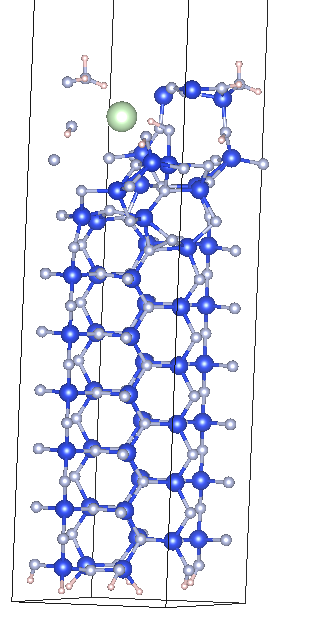

Visually estimate that it's between 0.36977 to 0.40572 C.

In [ ]:
np.array([0.36977, 0.40572]) * heavy_bomb.cell[2,2]

In [ ]:
from scipy.interpolate import interp1d


def damage_analysis(struct, crystal = xtl_n, 
                    resolution = 1, tolerance = 1e-2, 
                    rmax = 3, nbins = 200, 
                    elements = ["Si", "N"],
                    species=[7, 14, 6, 9], 
                    mindist = 10,
                    rcut=5.0, 
                    nmax=10,
                    lmax=9, 
                    sigma=0.5, 
                    periodic=1, #bool 
                    crossover=1,#bool
                    sparse=0, 
                    metric = 'rbf',
                    alpha = 1e-2,
                    threshold = 1e-6
                   ):
    
    cellheight = struct.cell[2,2]
    heights = np.arange(mindist, cellheight, resolution)
    copies = []
    rdfs = []
    soap_similarities = []
    
    desc = SOAP(species=species, 
             rcut=rcut, 
             nmax=nmax, 
             lmax=lmax, 
             sigma=sigma, 
             periodic=1, 
             crossover=1, 
             sparse=0)


    
    for zi in heights:
        copy = struct.copy()
        del copy[[atom.index for atom in copy if atom.position[2] > zi]]
        copies += [copy]
        
#         features = [preprocessing.normalize(desc.create(i)) for i in [crystal, copy]]
#         re = REMatchKernel(metric=metric, alpha=alpha, threshold=threshold)
#         soap_similarities += [re.create(features)[0, 1]]
        rdfs += Analysis(copy).get_rdf(rmax = rmax, 
                             nbins = nbins, 
                             elements = elements, 
                             return_dists = True)
#     plt.plot(heights, soap_similarities)
#     plt.vlines([16.2, 17.8], min(soap_similarities), max(soap_similarities))
#     plt.title('soap curve')
#     plt.show()

    xtlrdf, xtlr = Analysis(crystal).get_rdf(rmax = rmax, nbins = nbins, 
                                             elements = elements, return_dists = True)[0]
    xtlrdf = normalize(xtlrdf, xtlr)
    xtlrdf = interp1d(xtlr, xtlrdf)
    
    absdiffs = []
    sqdiffs = []
    
    for rdf,r in rdfs:
        rdf = normalize(rdf, r)
        absdiffs += [np.sum(np.abs(xtlrdf(r) - rdf))]
        sqdiffs += [np.sum((xtlrdf(r) - rdf)**2)]
    plt.plot(heights, absdiffs, label = "l1")
    plt.plot(heights, sqdiffs, label = "l2")
    plt.hlines(0, rmax, cellheight)
    plt.vlines([16.2, 17.8], 0, 30)
    plt.legend()
    plt.title('rdf comparison')
    
    return soap_similarities, absdiffs, sqdiffs, heights
    
    
        
damage_analysis_results = damage_analysis(heavy_bomb_copy, mindist=7)

In [ ]:
damage_analyses = [damage_analysis(thicc_bombarded[i], mindist = 7) for i in range(5)]

In [ ]:
def soap_fitter(struct, 
                species = [7, 14, 6, 0],
                periodic=True, 
                crossover=True,
                sparse=False, 
                metric = 'rbf', 
                crystal = xtl_n,
                mindist = 5,
               ):
    
    def soap_fitter_base(x,
                    rcut=5.0, 
                    nmax=10,
                    lmax=9, 
                    sigma=0.5, alpha = 1e-2,
                    threshold = 1e-6
                   ):
        nmax, lmax = int(np.floor(nmax)), int(np.floor(lmax))
    
        cellheight = struct.cell[2,2]
        heights = x
        copies = []
        soap_similarities = []

        desc = SOAP(species=species, 
                 rcut=rcut, 
                 nmax=nmax, 
                 lmax=lmax, 
                 sigma=sigma, 
                 periodic=periodic, 
                 crossover=crossover, 
                 sparse=sparse)



        for zi in heights:
            copy = struct.copy()
            del copy[[atom.index for atom in copy if atom.position[2] > zi]]
            copies += [copy]

            features = [preprocessing.normalize(desc.create(i)) for i in [crystal, copy]]
            re = REMatchKernel(metric=metric, alpha=alpha, threshold=threshold)
            soap_similarities += [re.create(features)[0, 1]]


        return soap_similarities
    
    return soap_fitter_base

def mbtr_fitter(struct, 
                species=["N","Si", "C", "F"],
                periodic=True, 
                crossover=True,
                sparse=False, 
                metric = 'rbf', 
                crystal = xtl_n,
                mindist = 5,
               ):
    
    def mbtr_fitter_base(x,
                         amplitude, bias,
                         rcut=5.0, 
                         n = 200,
                         scale=1,
                         sigma=0.02, 
                         alpha = 1e-2,
                         cutoff = 1e-3,
                         threshold = 1e-6,
                   ):
        n = int(n)
        
        del crystal[[atom.index for atom in crystal if atom.symbol not in species]]
        cellheight = struct.cell[2,2]
        heights = x
        copies = []
        similarities = []

        desc = MBTR(
            species = species,
            periodic=True,
            k2={
                "geometry": {"function": "distance"},
                "grid": {"min": 0, "max": rcut, "sigma": sigma, "n": n},
                "weighting": {"function": "exponential", "scale": scale, "cutoff": cutoff},
            },
            k3={
                "geometry": {"function": "cosine"},
                "grid": {"min": -1.0, "max": 1.0, "sigma": sigma , "n": n},
                "weighting": {"function": "exponential", "scale": scale, "cutoff": cutoff},
            },
            flatten=True,
            sparse=False,
        )
        desc.normalization = "l2_each"


        for zi in heights:
            copy = struct.copy()
            del copy[[atom.index for atom in copy if atom.position[2] > zi]]
            copies += [copy]

            features = [preprocessing.normalize(desc.create(i)) for i in [crystal, copy]]
            re = REMatchKernel(metric=metric, alpha=alpha, threshold=threshold)
            similarities += [re.create(features)[0, 1]]



        return scale*(np.array(similarities) - bias)
    
    return mbtr_fitter_base




In [ ]:
x = np.arange(7, thicc_bombarded[0].cell[2,2])
plt.plot(x, soap_fitter(heavy_bomb_copy)(x))

In [ ]:
thicc_bombarded = [vasp.read_vasp("../CONTCAR%d" % (i)) for i in range(1,6)]
for atoms in thicc_bombarded:
    del atoms[[atom.index for atom in atoms if atom.symbol not in ['Si', 'N']]]

x = np.arange(7, thicc_bombarded[0].cell[2,2])
mbtr_curves = []
for i, a in enumerate(thicc_bombarded):
    mbtr_curves += [mbtr_fitter(a)(x, 1, 0, rcut=5.0, 
                         n = 200,
                         scale=1,
                         sigma=0.02, 
                         alpha = 2,
                         cutoff = 1e-3,
                         threshold = 1e-6)]

In [ ]:
fig, axs = plt.subplots(5, 1, figsize = (30, 30))
for i, data in enumerate(mbtr_curves):
    axs[i].plot(x, data)

In [ ]:
soap_curves = []
for i, a in enumerate(thicc_bombarded):
    soap_curves += [soap_fitter(a)(x)]

In [ ]:
fig, axs = plt.subplots(5, 1, figsize = (30, 30))
for i, data in enumerate(soap_curves):
    axs[i].plot(x, data)

In [ ]:
thicc_bombarded = [vasp.read_vasp("../CONTCAR%d" % (i)) for i in range(1,6)]
for atoms in thicc_bombarded:
    del atoms[[atom.index for atom in atoms if atom.symbol not in ['Si', 'N']]]

x = np.arange(0, thicc_bombarded[0].cell[2,2])
for i, a in enumerate(thicc_bombarded):
    damage_analysis(a)
plt.legend()

In [ ]:
heavy_bomb_copy = heavy_bomb.copy()
del heavy_bomb_copy[[atom.index for atom in heavy_bomb_copy if atom.symbol not in ["Si", "N"]]]
plt.plot(x, mbtr_fitter(heavy_bomb_copy)(x, 1, 0))

Fitting curves:

In [ ]:
x = damage_analysis_results[3]
soap_trial_f = soap_fitter(heavy_bomb)
mbtr_trial_f = mbtr_fitter(heavy_bomb)

reference = max(damage_analysis_results[1]) - damage_analysis_results[1]
reference = reference/max(reference)
# soap_params, soap_cov = curve_fit(trial_f, x, reference, 
#                         bounds = (np.array([1, 1, 1, 1e-3, 1e-3, 1e-10]),
#                                   np.array([30, 30, 9, 1e2, 1e2, 1])
#                                  )
#                        )
mbtr_params, mbtr_cov = curve_fit(mbtr_trial_f, x, reference,
                                  p0 = [20, .999, 5, 200, 1, .02, 1e-2, 1e-3, 1e-6],
                                  bounds = (np.array([0, 0, 0, 1, 0, 0, 0, 0, 0]),
                                            np.array([1e2, 1, 30, 1000, 9, 1e2, 1e2, 1e2, 1])
                                           )
                                 )

In [ ]:
mbtr_params

In [ ]:
plt.plot(x, 20*np.array(mbtr_fitter(heavy_bomb)(x, *mbtr_params)))
plt.plot(x, reference)

In [ ]:
fit_result_soap_curve = trial_f(x, *params)

In [ ]:
plt.plot(x, fit_result_soap_curve)
plt.show()
plt.plot(x, reference);

## Diffusion

In [ ]:
from ase.md.analysis import DiffusionCoefficient
from ase import units

traj = vasp.read_vasp_xml("../vasprun.xml", index = slice(0, -1))
traj = [i for i in traj]
timestep = 1 * units.fs
natom = range(len(traj[0]) - 4, len(traj[0]))
D = DiffusionCoefficient(traj, timestep, natom)

In [ ]:
D.get_diffusion_coefficients()

## Postprocessing for amorphous batch structure

In [113]:
# simindices = np.append(np.arange(2, 10), np.arange(16, 22))
simindices = [0]

bombdata = {i :pd.read_csv("../aggregated_bomb%d.csv" % i, 
                    index_col=0) 
        for i in simindices}
quenchdata = {i : pd.read_csv("../aggregated_quench%d.csv" % i, 
                    index_col=0) 
        for i in simindices}
eqdata = { i: pd.read_csv("../aggregated_eq%d.csv" % i, 
                    index_col=0) 
        for i in simindices}
data = {"bomb": bombdata, "quench": quenchdata, "eq":eqdata}


aggregated = {}
for i in simindices:
    for step in ["bomb", "quench", "eq"]:
        aggregated["%i-%s" % (i, step)] = data[step][i].sum(axis = 1)
aggregated = pd.DataFrame(aggregated)
# aggregated = aggregated.sum()
# aggregated
aggregated.style.set_caption("removed species")

,0-bomb,0-quench,0-eq
Si,0,3,0
N,23,16,0
H,5047,1563,94
Ar,72,67,3
F,1626,665,22
C,1709,509,5


In [114]:
(aggregated/170).sum(axis = 1)

Si     0.017647
N      0.229412
H     39.435294
Ar     0.835294
F     13.605882
C     13.076471
dtype: float64

In [115]:
(aggregated/170).style.set_caption("normalized by #runs")

,0-bomb,0-quench,0-eq
Si,0.000000,0.017647,0.000000
N,0.135294,0.094118,0.000000
H,29.688235,9.194118,0.552941
Ar,0.423529,0.394118,0.017647
F,9.564706,3.911765,0.129412
C,10.052941,2.994118,0.029412


In [17]:
bombdata.keys()

dict_keys([0])

In [40]:
aggregated.sum()/ (170 * 360)

0.2223529411764706

In [ ]:
traj = [i for i in vasp.read_vasp_xml("../vasprun.xml", index = slice(0, -1))]

In [ ]:
view(traj)

In [ ]:
out = traj[15]
P = [[3, 0, 0], [0, 3, 0], [0, 0, 1]]
out = make_supercell(out, P)
xyz.write_xyz('../POSCAR0.xyz', out)

In [ ]:
# plt.figure(figsize = (5, 2))
(aggregated.T / (170 * 350)).plot(y = ['Si', 'N', 'H'], figsize = (10, 5));
plt.ylabel("Sputter yield (# atoms ejected/total atoms)")
plt.xlabel("Bombardment progress")

In [ ]:
# for i, tbl in enumerate(bonds):
#     tbl.to_csv("bonds%")

In [ ]:
siremoved = {key:i for key, i in enumerate(data) if sum(i.loc["Si"]) > 0 }

In [ ]:
siremoved.keys()

In [ ]:
siremoved[8]

In [ ]:
siremoved[9]

In [ ]:
print(sum(aggregated.loc["N"]))
print(sum(aggregated.loc["Si"]))

## Analyze composition change

In [ ]:
datadir = "../bomb/" #bare bombardment, v0.13 = 35.0 eV, 0.135 = 37.7 eV, .14 = 40.55 eV
geometries = {}
for i in os.listdir(datadir):
    if ".gen" in i:
        key = re.search(r"\d+-\d+", i)
#         key = re.search(r"\d+", i)
        if key:
            key = key.group(0)
#             print(key)
            geometries[key] =  gen.read_gen(datadir + i)
# geometries = {'lol': xtl2x2}

In [ ]:
view([geom for geom in geometries.values()])

In [ ]:
view(xtl2x2)

In [ ]:
# show distribution of undercoordination as a function of z
import seaborn as sns
sns.set_theme(style="darkgrid")

zs = []
for i, frame in enumerate(geometries.values()):
    Si = frame[[atom.index for atom in frame if atom.symbol == "Si"]]
    zs += [atom.z for atom in Si]
temp = sns.kdeplot(zs, bw_adjust = 0.5, label = i, common_norm=True)
numSi = len(zs)
# plt.legend()
# plt.xlim(0, 22)
plt.xlabel("z (Å)")
plt.ylabel("density")
plt.title("Z distribution of Si in amorphous bombardment")

In [ ]:
zs = []
for i, frame in enumerate(geometries.values()):
    Si = frame[[atom.index for atom in frame if atom.symbol == "N"]]
    zs += [atom.z for atom in Si]
temp2 = sns.kdeplot(zs, bw_adjust = 0.5, label = i, common_norm=True)
numN = len(zs)
# plt.legend()
plt.xlabel("z (Å)")
plt.ylabel("density")
plt.title("Z distribution of N in amorphous bombardment")


In [ ]:
zs = []
for i, frame in enumerate(geometries.values()):
    N = frame[[atom.index for atom in frame if atom.symbol == "N"]]
    Si = frame[[atom.index for atom in frame if atom.symbol == "Si"]]
    zs += [atom.z for atom in Si]
    zs += [atom.z for atom in N]
temp3 = sns.kdeplot(zs, bw_adjust = 0.5, label = i, common_norm=True)
# plt.legend()
plt.xlabel("z (Å)")
plt.ylabel("density")
plt.title("Z distribution of all atoms in amorphous bombardment")


In [ ]:
# zs = []
# for i, frame in enumerate(geometries.values()):
#     N = frame[[atom.index for atom in frame if atom.symbol == "N"]]
#     Si = frame[[atom.index for atom in frame if atom.symbol == "Si"]]
#     zs += [atom.z for atom in Si]
#     zs += [atom.z for atom in N]
# numN = len(zs)
# plt.legend()
# plt.xlabel("z (Å)")
# plt.ylabel("density")
# plt.title("Z distribution of all atoms in amorphous bombardment")

In [ ]:
numSi/numN,numSi, numN

In [ ]:
3/7

In [ ]:
from scipy.integrate import quad,trapz
quad(interp, min(plotx), max(plotx)), trapz(interp(plotx), x = plotx)

In [ ]:
from scipy.interpolate import interp1d
x, y = temp.lines[0].get_xdata(), temp.lines[0].get_ydata()
x2, y2 = temp2.lines[0].get_xdata(), temp2.lines[0].get_ydata()
interp = interp1d(x, y*1, kind = 'cubic')
interp2 = interp1d(x2, y2*1, kind = 'cubic')
minx = max(min(x), min(x2))
maxx = min(max(x), max(x2))
#     plotx = np.arange(minx, maxx, .1)    
plotx = np.arange(minx, maxx, .1)
plt.plot(plotx, numSi * interp(plotx)/(numSi * interp2(plotx) + numN * interp(plotx)), label = i)
plt.hlines(3/7, minx, maxx)
plt.xlim(minx, 22)
plt.ylim(-0.0, 1)
# plt.legend()
plt.title("relative ratio of Si/N as estimated by KDE ")
plt.xlabel("height in slab (Å)")

In [ ]:
plt.plot(plotx, interp(plotx))
plt.plot(plotx, interp2(plotx) + interp(plotx))
plt.legend(['Si dist', 'Si + N dist'])

In [ ]:
plt.plot(plotx, 3 * interp(plotx))
plt.plot(plotx, 4 * interp2(plotx) + 3 * interp(plotx))
plt.legend(['Si dist', 'Si + N dist'])

In [ ]:
plt.plot(plotx, interp2(plotx)/interp(plotx))
plt.xlim(0, 20)
plt.ylim(0, 5)

In [ ]:
# show distribution of undercoordination as a function of z
import seaborn as sns
sns.set_theme(style="darkgrid")



for i, frame in enumerate(traj[::5]):
    Si = frame[[atom.index for atom in frame if atom.symbol == "Si"]]
    zs = [atom.z for atom in Si]
    temp = sns.kdeplot(zs, bw_adjust = 0.1, label = i)
plt.legend()
plt.xlabel("z (Å)")
plt.ylabel("density")
plt.title("Z distribution of Si in amorphous bombardment")

In [ ]:
for i, frame in enumerate(traj[::5]):
    Si = frame[[atom.index for atom in frame if atom.symbol == "N"]]
    zs = [atom.z for atom in Si]
    temp2 = sns.kdeplot(zs, bw_adjust = 0.1, label = i)
plt.legend()
plt.xlabel("z (Å)")
plt.ylabel("density")
plt.title("Z distribution of N in amorphous bombardment")

In [ ]:
from scipy.interpolate import interp1d
for i in range(4):
    x, y = temp.lines[i].get_xdata(), temp.lines[i].get_ydata()
    x2, y2 = temp2.lines[i].get_xdata(), temp2.lines[i].get_ydata()
    interp = interp1d(x, y, kind = 'cubic')
    interp2 = interp1d(x2, y2, kind = 'cubic')
    minx = max(min(x), min(x2))
    maxx = min(max(x), max(x2))
#     plotx = np.arange(minx, maxx, .1)    
    plotx = np.arange(5, 16, .1)
    plt.plot(plotx, interp(plotx)/interp2(plotx), label = i)
    plt.hlines(1, 5, 15)
plt.legend()
plt.title("relative ratio of Si/N as estimated by KDE ")

## Density calculation

In [97]:
datadir = "../postbomb/" #bare bombardment, v0.13 = 35.0 eV, 0.135 = 37.7 eV, .14 = 40.55 eV
geometries = {}
for i in os.listdir(datadir):
    if ".gen" in i:
        key = re.search(r"\d+-\d+", i)
#         key = re.search(r"\d+", i)
        if key:
            key = key.group(0)
#             print(key)
            geometries[key] =  gen.read_gen(datadir + i)

In [99]:
total = 0
for i in geometries.values():
    for atom in i:
        if atom.symbol == "C" and atom.position[2] < 18.0:
            total+=1
            
total
        

115

Calculate reference density:

In [ ]:
view(amorphous)

In [ ]:
# base density of silicon nitride = 3.17 g/cm^3 according to Google

# maxz = np.max([atom.position[2] for atom in amorphous if atom.symbol in ['Si', 'N']])
# minz = np.min([atom.position[2] for atom in amorphous if atom.symbol in ['Si', 'N']])
height = maxz - minz
boxlen = amorphous.cell[0, 0]
np.sum(amorphous.get_masses() * amu2g)/ (boxlen ** 2 * height * a2cm**3)  

In [179]:
def density_dist(slab, binwidth = 2, maxz = 30, elems = None):
    bins = np.arange(0, maxz, binwidth)
    
    boxlen = slab.cell[0, 0]
    buckets = bins * 0
    buckets = np.array(buckets)

    for atom in slab:
        if elems and atom.symbol not in elems:
            continue
        zpos = atom.position[2]
        bucket = int(zpos//binwidth)
        buckets[bucket] += atom.mass
    volume = boxlen**2 * binwidth * a2cm**3
    density = buckets * amu2g / volume
    
    return bins, density


# plt.step(bins, density)
# plt.xlabel("height (Å)")
# plt.ylabel("density (g/cm3)")

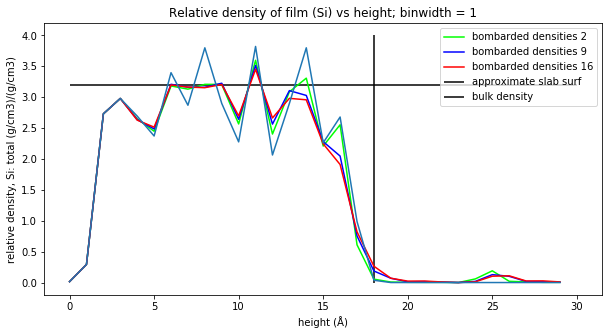

In [197]:
plt.figure(figsize = (10, 5))
binwidth,maxz = 1, 30

bins, density = density_dist(amorphous, binwidth, maxz)

for run, color in zip([2,9,16], ['lime', 'blue', 'red']):
    datadir = "../bomb%d_results/" % run #bare bombardment, v0.13 = 35.0 eV, 0.135 = 37.7 eV, .14 = 40.55 eV
    geometries = {}
    for i in os.listdir(datadir):
        if ".gen" in i:
            key = re.search(r"\d+-\d+", i)
    #         key = re.search(r"\d+", i)
            if key:
                key = key.group(0)
    #             print(key)
                geometries[key] =  gen.read_gen(datadir + i)

    plotx = np.arange(0, maxz, binwidth)
    
    Sidensity = [density_dist(geom,binwidth, maxz, ["Si"])[1] for geom in geometries.values()]
    totaldensity = [density_dist(geom, binwidth, maxz)[1] for geom in geometries.values()]
    reldensities = [[x/y if y > 0 else 0 for x, y in zip(i, j)] 
                    for i, j in zip (Sidensity, totaldensity)]
    
#     densities = np.vstack(reldensities)
    densities = np.vstack(totaldensity)
                           
    avg_densities = np.mean([i for i in densities], axis = 0)
    sd_densities = np.std([i for i in densities], axis = 0)
    plt.plot(plotx, avg_densities, color = color, label = 'bombarded densities %s' % run)
#     plt.fill_between(plotx, avg_densities - 1.96*sd_densities, avg_densities + 1.96*sd_densities,
#                      color=color, alpha=0.1, label = '95 percent CI, %d' % run)
basebins, basedensity = density_dist(amorphous, binwidth, maxz)
basebinsSi, basedensitySi = density_dist(amorphous, binwidth, maxz, ['Si'])
baseRelDensity = [x/y if y > 0 else 0 for x,y in zip(basedensitySi, basedensity)]
# plt.plot(basebins, baseRelDensity, label = 'amorphous base case', color = 'brown')
plt.plot(basebins, basedensity)
# plt.vlines(18, ymin = 0, ymax = 0.7, label = 'approximate slab surf')
plt.vlines(18, ymin = 0, ymax = 4, label = 'approximate slab surf')
plt.hlines(3.2, xmin = 0, xmax = maxz, label = 'bulk density')
plt.title('Relative density of film (Si) vs height; binwidth = %d' % binwidth)
plt.xlabel("height (Å)")
plt.ylabel("relative density, Si: total (g/cm3)/(g/cm3)")
plt.legend();

In [214]:
np.mean(basedensity[np.bitwise_and(basebins < 15, basebins > 5)])

3.092190805598879

# Miscellaneous editing

## DB detection

### For a trajectory

In [ ]:
traj = xyz.read_xyz("../0-0.xyz", index = slice(0, -1, 1000))
traj = [i for i in traj]
for i in traj:
    i.cell = gen.read_gen("../input_hterm.gen").cell
    i.pbc = [True, True, True]
view(traj)

In [ ]:
traj_coord = [coordLabeller(slab, 0, angle_tolerance = 0.25, bond_tolerance = 0.15) for slab in traj]
for i, slab in enumerate(traj):
    relCoord = traj_coord[i][0]
    bonds = traj_coord[i][1]
    slab.set_initial_charges([relCoord[atom.index] for atom in slab])
view(traj)

In [ ]:
unders = []
overs = []
for i, slab in enumerate(traj):
    relCoord = traj_coord[i][0]
    bonds = traj_coord[i][1]
    unders += [np.sum([j == -1 for j in relCoord.values()])]
    overs += [np.sum([j == 1 for j in relCoord.values()])]
plt.plot(unders, label = 'unders')
plt.plot(overs, label = 'overs')
plt.legend()


In [ ]:
fullbonds = {"Si": 4, "N": 3, "H":1, "Ar": 0}
coordinationlists = {}
for i in np.arange(-3, 4):
    coordinationlists[i] = []

for i, slab in enumerate(traj):
    bonds = traj_coord[i][1]
    charges = {}
    for atom in slab:
        idx = atom.index
        species = atom.symbol
        numbonds = len(bonds[idx])
        charges[idx] = numbonds - fullbonds[species]
    for i in coordinationlists.keys():
        coordinationlists[i] += [sum([charges[j] == i for j in charges.keys()])]
    
    
# slab.set_initial_charges([charges[atom.index] for atom in slab])
# view(traj)
        
for i, values in coordinationlists.items():
    if i == 0:
        continue
    plt.plot(np.linspace(0, 10, 22), np.array(values)/len(slab), label = i)
plt.legend()
plt.title("Coordination defects vs time")
plt.xlabel("bombardment progress")
plt.ylabel("number of atoms with {#} coordination defects")
        

In [ ]:
np.unique(list(charges.values()))

### For single structure

In [ ]:
slab = gen.read_gen("../geom.out.gen")
# view(slab)

In [ ]:
coords = coordLabeller(slab, 0, angle_tolerance = 0.15, bond_tolerance = 0.25)

In [ ]:
109.5 * (1 - .15)

In [ ]:
slab.set_initial_charges([coords[0][atom.index] for atom in slab])
view(slab)

In [ ]:
coords[1][70]

In [ ]:
for tol in np.arange(0, .5, .05):
    slab = gen.read_gen("../input_hterm.gen") #crystalline, more bomb
    slab = traj[0]
    relCoord, bonds = coordLabeller(slab, 0, angle_tolerance=.25, bond_tolerance = tol)
    slab.set_initial_charges([relCoord[atom.index] for atom in slab])
    print("tol: ", tol, "defects: ", sum([abs(i) for i in relCoord.values()]))
    # slab.edit()
    # view(slab)


### For collection of geometries

In [242]:
zcut = 10
datadir = "../bomb16_results/" #bare bombardment, v0.13 = 35.0 eV, 0.135 = 37.7 eV, .14 = 40.55 eV
geometries = {}
for i in os.listdir(datadir):
    if ".gen" in i:
        key = re.search(r"\d+-\d+", i)
        if key:
            key = key.group(0)
            geometries[key] =  gen.read_gen(datadir + i)

#subset:
np.random.seed(429)
choices = np.random.choice(list(geometries.keys()), size = 10)
geometries = {choice: geometries[choice] for choice in choices}

for key, value in geometries.items():
    geometries[key] = value[[atom.position[2] > zcut for atom in value]]

In [219]:
view(list(geometries.values()))

In [243]:
traj_coord = {key: coordLabeller(slab, 0, angle_tolerance = 0.25, bond_tolerance = 0.15, minz = 12 ) 
              for key, slab in geometries.items()}

In [241]:
overs2 = overs
unders2 = unders

In [237]:
overs9 = overs
unders9 = unders 

In [245]:
overs16 = overs
unders16 = unders

In [247]:
np.mean(unders2), np.mean(unders9), np.mean(unders16)

(15.0, 17.7, 19.5)

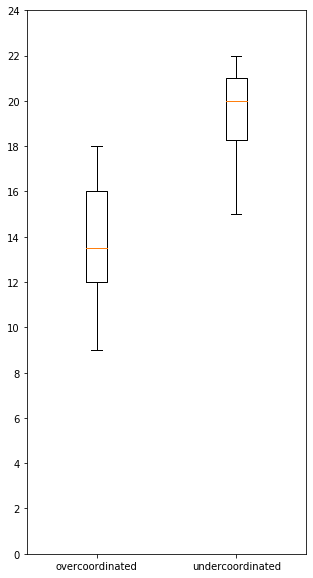

In [250]:
overs = [np.sum([i == 1 for i in relCoord.values()]) for relCoord, bonds in traj_coord.values()]
unders = [np.sum([i == -1 for i in relCoord.values()]) for relCoord, bonds in traj_coord.values()]
plt.figure(figsize = (5, 10))
plt.boxplot(np.array([overs16,unders16]).T, labels = ['overcoordinated', 'undercoordinated'], );
plt.yticks(np.arange(0, 25, 2));

### From saved data

In [ ]:
coordination_tables = [pd.read_csv("coordination_table%d.csv" % i, index_col = 0) for i in range(7)]

In [ ]:
relative_coordinations = [pd.read_csv("relativeCoordinations%d.csv" % i, index_col = 0) for i in range(7)]

In [ ]:
coordination_tables[0]

In [ ]:
relative_coordinations[0]

In [ ]:
coordination_zs = []
for i, tbl in enumerate(relative_coordinations):
    undercoordinated_z = []
    overcoordinated_z = []
    fully_coordinated_z = []
    for trial in tbl.columns:
        struct = gen.read_gen("../bomb%d/output%s.gen" % (i, trial))
        for idx in tbl.index:
            if tbl[trial][idx] == -1:
                zloc = struct[idx].z
                if zloc > 0 and zloc < 13:
                    undercoordinated_z += [zloc]
            elif tbl[trial][idx] == 0:
                zloc = struct[idx].z
                if zloc > 0 and zloc < 13:
                    fully_coordinated_z += [zloc]
    coordination_zs += [(undercoordinated_z, overcoordinated_z, fully_coordinated_z)]

In [ ]:
sns.set_theme(style="darkgrid")
for i, t in enumerate(coordination_zs):
    if i % 2 != 0:
        continue
    u, o, f = t
#     sns.kdeplot(u, bw_adjust = 0.1, label = 'undercoordinated atoms')
#     sns.kdeplot(u, bw_adjust = 0.05, label = 'full - %d' % i, common_norm=True)
    plt.hist(u, bins = np.arange(0, 13, 0.05), density = False, 
             histtype=u'step', label = 'batch %d' %i)
#     print(min(u), max(u))
    plt.legend()
    plt.xlim(5, 13)
    plt.ylim(0, 700)
    plt.xlabel("z (Å)")
    plt.ylabel("density")
    plt.title("Total of undercoordinated atoms by batch")

In [ ]:
sns.set_theme(style="darkgrid")
for i, t in enumerate(coordination_zs):
    if i % 2 != 0:
        continue
    u, o, f = t
#     sns.kdeplot(u, bw_adjust = 0.1, label = 'undercoordinated atoms')
#     sns.kdeplot(u, bw_adjust = 0.05, label = 'full - %d' % i, common_norm=True)
    plt.hist(f, bins = np.arange(0, 13, 0.05), density = False, 
             histtype=u'step', label = 'full - %d' %i)
#     print(min(u), max(u))
    plt.legend()
#     plt.xlim(0, 5)
    
    plt.xlabel("z (Å)")
    plt.ylabel("density")
    plt.title("Total of fully coordinated atoms by batch")

In [ ]:
# show distribution of undercoordination as a function of z
import seaborn as sns
# sns.set_theme(style="darkgrid")

path1 = "../hterm_final.gen"
path2 = "../amorphous_bombed_0.gen"
test1 = gen.read_gen(path1).copy()
test2 = gen.read_gen(path2).copy()
del test1[[atom.index for atom in test1 if atom.symbol not in ["Si", "N"]]]
del test2[[atom.index for atom in test2 if atom.symbol not in ["Si", "N"]]]


zs1 = [atom.z for atom in test1]
zs2= [atom.z for atom in test2]
sns.kdeplot(zs1, bw_adjust = 0.1, label = 'amorphous')
sns.kdeplot(zs2, bw_adjust = 0.1, label = 'amorphous, bombed 0')
plt.legend()
plt.xlabel("z (Å)")
plt.ylabel("density")
plt.title("Z distribution of Si, N atoms in amorphous bombardment")

In [ ]:
bombfiles = ["../bomb%d/" % i for i in np.arange(7)]
coordination_tables = []
relCoords_all = []
bonds_all = []
for datadir in bombfiles:
    coordination_dict = {}
    relCoord_dict = {}
    bonds_dict = {}
    for i in os.listdir(datadir):
        if ".gen" in i:
            key = re.search(r"\d+-\d+", i)
            if key:
                key = key.group(0)
                struct = gen.read_gen(datadir + i)
                relativeCoordinations, bonds = coordLabeller(struct, image = 0)
                relcounts = {
                    "undercoordinated": len([i for i in relativeCoordinations.values() if i == -1]),
                    "overcoordinated": len([i for i in relativeCoordinations.values() if i == 1]),
                    "fully coordinated": len([i for i in relativeCoordinations.values() if i == 0])}
                coordination_dict[key] = relcounts
                relCoord_dict[key] = relativeCoordinations
                bonds_dict[key] = bonds
    coordination_tables += [pd.DataFrame(coordination_dict)]
    relCoords_all += [pd.DataFrame(relCoord_dict)]
    bonds_all += [pd.DataFrame(bonds_dict)]
    

In [ ]:
for i in coordination_tables:
    print(i.mean(axis = 1))
plotx = np.arange(7)
plt.plot(plotx, [i.mean(axis = 1)['undercoordinated'] for i in coordination_tables], label = 'undercoordinated')
plt.plot(plotx, [i.mean(axis = 1)['overcoordinated'] for i in coordination_tables], label = 'overcoordinated')
plt.plot(plotx, [i.mean(axis = 1)['fully coordinated'] for i in coordination_tables], label = 'fully coordinated')
plt.legend()
plt.xlabel("")

In [ ]:
from ase.neighborlist import neighbor_list
nl = neighbor_list('i', slab, 
              cutoff = {
                  ("Si", "Si"): 2.6,
                  ("Si", "H"): 1.82002,
                  ("Si", "N"): 2.12002,
                  ("N", "N"): 1.8826,
                  ("H", "N"): 1.2,
              }
             )
print(np.bincount(nl))

In [ ]:
#amorphous editing
# slab = gen.read_gen("../amorphous_input.gen")
# slab = gen.read_gen("../amorphous_input_hterm.gen")
amorphous_slab = gen.read_gen("../geom.out.gen")
slab.constraints = FixAtoms(np.arange(80))
# view(slab)
# slab.edit()

In [ ]:
view(slab)

In [ ]:
view(heavy_bomb)

In [ ]:
coordinations = [coordLabeller(slab, image = 0, tolerance = .25) for slab in 
                 [amorphous_slab, xtl2x2_sifterm, xtl2x2, heavy_bomb]]

In [ ]:
relcounts = [(
    len([i for i in relativeCoordinations.values() if i == -1]),
    len([i for i in relativeCoordinations.values() if i == 1]),
    len([i for i in relativeCoordinations.values() if i == 0])
 ) 
 for relativeCoordinations, newBonds in coordinations]

In [ ]:
relcounts

In [ ]:
([slab[i] for i, value in coordinations.items() if value == -1])

In [ ]:
([slab[i] for i, value in coordinations.items() if value == 1])

In [ ]:
print(len([slab[i] for i, value in coordinations.items() if value == -1]))
print(len([slab[i] for i, value in coordinations.items() if value == 1]))

In [ ]:
coordinations, undercoordinated =  coordLabeller(slab)
slab.set_initial_charges([int(coordinations[atom.index]) for atom in slab])
view(slab)
# sum([atom.charge for atom in slab])
# slab.edit()

In [ ]:
#EUV slab, no SCC
energies = pd.read_csv("../euv/f2adsorbed/energies", header = None)
reference = -11015.3982
f2ref = -234.4398
energies = energies - reference - f2ref
energies.describe()

In [ ]:
#EUV slab, no SCC
energies = pd.read_csv("../euv/fadsorbed/energies", header = None)
reference = -11015.3982
# fref = -115.2462
fref = f2ref/2 
energies = energies - reference - fref
energies.describe()

In [ ]:
temp = gen.read_gen("../newinput.gen")
temp.constraints = FixAtoms(np.arange(80))
# constrainedindices = np.concatenate((np.arange(4, 25), 
#                                     np.arange(29,69),
#                                     np.arange(72, 93),
#                                     np.arange(97, 137),
#                                     np.arange(140, 161),
#                                     np.arange(165, 205),
#                                     np.arange(208, 229),
#                                     np.arange(233, len(temp))
#                                    ))
# temp.constraints = FixAtoms(constrainedindices)
view(temp)
# temp.edit()

In [ ]:
view(gen.read_gen("../input.gen"))

In [ ]:
gen.write_gen("../input.gen", vasp.read_vasp("../CONTCAR_amorphous"))

In [ ]:
gen.write_gen("../h2nsif3.gen", list(xyz.read_xyz("../h2nsif3.xyz"))[0])

In [ ]:
view(gen.read_gen("../h2nsif3.gen"))

In [ ]:
temp = gen.read_gen("../h2nsif3.gen")
temp.cell = Cell(np.array([[15,0,0],
                  [0,15,0],
                  [0,0,15]], dtype = float)
                  )
temp.pbc = True
# vasp.write_vasp("../POSCAR", temp, sort=True, vasp5=True)
gen.write_gen("../h2nsif3.gen", temp)

In [ ]:
temp = list(xyz.read_xyz("../anneal0-0.xyz", slice(0, -1)))
for i in temp:
    i.cell = xtl2x2.cell
view(temp)

In [ ]:
hindices = [atom.index for atom in temp[1002] if atom.symbol == "H"]
hpositions = []
for frame in temp:
    hpositions += [[atom.position for atom in frame[hindices]]]
hpositions = np.array(hpositions)

In [ ]:
hpositions.shape

Sanity check

In [ ]:
np.all(np.array([atom.position for atom in temp[1002] if atom.symbol == 'H']) == hpositions[1002, :, :])

In [ ]:
reference_positions = hpositions[2002, :, :]

In [ ]:
differences = (hpositions - reference_positions)

In [ ]:
distances = np.sum(differences**2, axis = 2)

In [ ]:
distances.shape

In [ ]:
for i in np.arange(distances.shape[1]):
    plt.plot(np.arange(distances.shape[0])/2, distances[:, i])
plt.xlabel("time (fs) from start of bombardment run")
plt.ylabel("displacement (Å)")
plt.title("H displacement (referenced to end of quench run) as a function of time;\n\
0.5 ps NVE bombardment, 0.5 ps quench to 300 K, and 5 ps NVT;\n Run 0-0");

### Bond formation

In [107]:
datadir = "../bomb/" #bare bombardment, v0.13 = 35.0 eV, 0.135 = 37.7 eV, .14 = 40.55 eV
geometries = {}
for i in os.listdir(datadir):
    if ".gen" in i:
        key = re.search(r"\d+-\d+", i)
        if key:
            key = key.group(0)
            geometries[key] =  gen.read_gen(datadir + i)

#subset:
# np.random.seed(429)
# choices = np.random.choice(list(geometries.keys()), size = 10)
# geometries = {choice: geometries[choice] for choice in choices}

# for key, value in geometries.items():
#     geometries[key] = value[[atom.position[2] > zcut for atom in value]]

In [108]:
analyses = {key: Analysis(item) for key, item in geometries.items()}

average number of final C-F bonds = 16.4


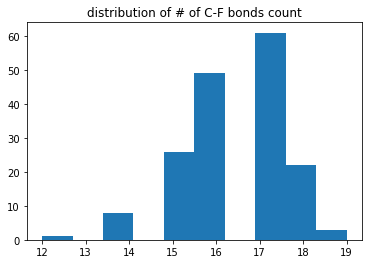

In [111]:
totalbonds = []
e1 = "C"
e2 = "F"
form = False
for key, analysis in analyses.items(): 
    try:
#         print(key, len(analysis.get_bonds("C", "N", unique = True)[0]))
        totalbonds += [len(analysis.get_bonds(e1, e2, unique = True)[0])]
    except:
        print('error on {}'.format(key))
if form:
    print('percent runs with {}-{} bond formation = {}'.format(e1, e2, np.sum(totalbonds)/170))
else:
    print('average number of final {}-{} bonds = {}'.format(e1, e2, np.sum(totalbonds)/170))
plt.hist(totalbonds)
if form:
    plt.title('distribution of # of {}-{} bonds formed'.format(e1, e2));
else:
    plt.title('distribution of # of {}-{} bonds count'.format(e1, e2));

In [105]:
len(Analysis(gen.read_gen("../bomb_inputs/input0-0.gen"))\
    .get_bonds("C", "F", unique = True)[0])

20

## xyz to POSCAR

In [18]:
temp = pd.read_clipboard(header = None)
temp

,0
0,-7.9332
1,-6.1905
2,-6.8660
3,-5.1233
4,-6.9211
5,-5.1784


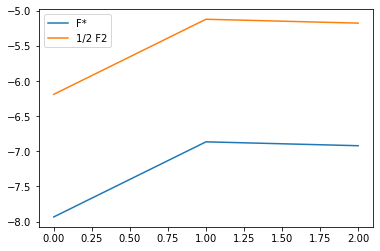

In [22]:
plt.plot(np.arange(3), temp[::2], label = 'F*')
plt.plot(np.arange(3), temp[1::2], label = '1/2 F2')
plt.legend()

In [15]:
s = xyz.read_xyz("../output.xyz")
s = list(s)[0]
# s.euler_rotate(45, 0, 0, center = 'COM')
s.translate([10, 10, 10])
s.cell = [20,20,20]
view(s)
vasp.write_vasp("../POSCAR", s, direct = True, sort=True, vasp5=True)
# s.edit()

In [ ]:
P = np.array([
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 1]
])
supercell = make_supercell(s, P)
view(supercell)
# supercell.edit()

## Basic optimization

In [ ]:
from ase.build import molecule
from ase.calculators.emt import EMT
from ase.optimize.fire import FIRE as QuasiNewton

# Optimise molecule
initial = molecule('C2H6')
initial.set_calculator(EMT())
relax = QuasiNewton(initial)
relax.run(fmax=0.05)

initial.cell = xtl_n.cell

vasp.write_vasp("../POSCAR_ethane", initial, vasp5= True)

view(initial)

## Gridding

### DFTB

#### Random gridding

In [53]:
from ase.build import add_vacuum
ref = gen.read_gen("../input-5-4")
# ref.constraints = FixAtoms(np.arange(80))
# add_vacuum(ref, 15)
view(ref)

# ref.edit()

In [44]:
vasp.write_vasp("../POSCAR", ref, sort = True, vasp5 = True)

Add adsorbate

In [45]:
refPosition = [8.9, 5.58]

In [54]:
np.random.seed(429)

# ref = xtl2x2 
num_dirs = 4
runs_per_dir = 17 #4 cores per run, 68 cores on st2/ 24 cores on ls5
output_dir = "../inputs/"
i = 0
# refz = ref.positions[-1,2]
for d in range(num_dirs):
    for run in range(runs_per_dir):
        
        s = ref.copy()
#         P = np.array([[2, 0, 0],
#                       [0, 1, 0],
#                       [0, 0, 2]
#                      ])
#         supercell = make_supercell(s, P, wrap=False)
#         zcoord = 2
#         offset = 6
#         slabmax = max(s, key = lambda x: x.position[1]).position[1]
        p = ref.cell.cartesian_positions(np.random.random(3)) #z coord needs dummy var
#         p = np.array(refPosition) + np.random.random(2) * offset - offset/2
#         add_adsorbate(s, 'Ar', height =  6, position = p[:2])
        add_adsorbate(s, mef, height =  2, position = p[:2])
#         nearbyAtoms = [np.linalg.norm(p[::2] - atom.position[::2]) < 1.5 
#                        for atom in supercell] # hacky way of omitting y from list of x, y, z
#         try:
#             sitemax = max(supercell[nearbyAtoms], key = lambda x: x.position[1]).position[1]
#         except:
#             sitemax = max(s, key = lambda x: x.position[1]).position[1]
#         if sitemax > 50:
#             print(p)
#             print('%d-%d' % (d,run))
        
#         s.append(Atom('Ar', position = (p[0], slabmax + zcoord, p[2])))
#         s.append(Atom('F', position = (p[0], sitemax + zcoord, p[2])))
#         s.append(Atom('F', position = (p[0], sitemax + zcoord + 1.2, p[2])))
#         gen.write_gen(output_dir + "input%d-%d.gen" % (d, run), s)
        gen.write_gen(output_dir + "input%d" % (d * 17 + run), s)
#         gen.write_gen(output_dir + "input%d" % (run + 1), s)
#         i += 1

view([gen.read_gen(output_dir + i) for i in os.listdir(output_dir)])

In [31]:
ref.constraints = FixAtoms(np.arange(80))
view(ref)

In [ ]:
len(os.listdir(output_dir))

In [ ]:
temp = gen.read_gen('../inputs/input7-3')
temp.constraints = FixAtoms(np.arange(32))
view(temp)

#### Regular gridding


In [ ]:
view(xtl2x2)

In [ ]:
# xtl2x2 = gen.read_gen("../input.gen")
outstruct = list(xyz.read_xyz("../training/crystal/100K.xyz"))[0]
# outstruct = [i for i in xyz.read_xyz("../training/crystal/1000K.xyz", index = -1)][0]
# outstruct = vasp.read_vasp("../CONTCAR")
del outstruct[[atom.index for atom in outstruct if atom.symbol == 'Ar']]
outstruct.cell = xtl2x2.cell
outstruct.pbc = True
order = [atom.index for atom in sorted(outstruct, key = lambda atom: atom.position[2])]

tempstruct = Atoms(sorted(outstruct, key = lambda atom: atom.position[2]))
del outstruct[[atom.index for atom in outstruct]]
outstruct += tempstruct
outstruct.constraints = FixAtoms(np.arange(32))
# view(outstruct)

hf = Atoms("HF", positions=np.array([(0,0,0), (0,0,1)]))
gridpts = np.linspace(0, 1, 9)
x, y = np.meshgrid(gridpts, gridpts)
z = np.zeros(x.shape)
coords = list(zip(x.flatten(),y.flatten(),z.flatten()))
coords = list(map(outstruct.cell.cartesian_positions, coords))
adsorbedStructs= []
for xi, yi, zi in coords:
    adsorbedStruct = outstruct.copy() 
    add_adsorbate(adsorbedStruct, mef, position = (xi, yi), height = 1)
    adsorbedStructs += [adsorbedStruct]
    
view(adsorbedStructs)
for i, s in enumerate(adsorbedStructs):
    gen.write_gen("input%d" % i, s)
#     vasp.write_vasp("input%d"%i, s, sort = True, vasp5= True)

### VASP

In [ ]:
#for 25 grid pts

i = 1
for _x in np.arange(0, 1, .2):
    for _y in np.arange(0, 1, .2):
        s = xtl_si.copy()
        x, y, z = xtl_si.cell.cartesian_positions([_x, _y, 0])
        add_adsorbate(s, cf4, height = 2, position = (x, y))
        s = Atoms(sorted(s, key = lambda x: x.symbol))
        s.cell = xtl_si.cell
        vasp.write_vasp("../POSCAR" + str(i), s, 
                        label = 'cf4 on nrich', vasp5=True)
        i += 1

show_atoms_grid([vasp.read_vasp("../POSCAR" + str(i)) for i in range(1,26)])

## Seeding random velocities

In [ ]:
np.random.seed(429)
velodir = "../velodir/"
for i in os.listdir(velodir):
    with open(velodir + i, 'a') as f:
        print(f)
        f.write(" ".join(np.array([0, -np.random.randint(100, 200), 0], dtype = str)))

## Finding atoms above/below some z coordinate

### Create dangling bond on each site

In [ ]:
src = vasp.read_vasp("reference_files/CONTCAR_sirich") 
cutoff_elems = ['H']
zcutoff = 10
cutoff_atoms = [atom for atom in src if 
 atom.symbol in cutoff_elems and atom.position[2] > zcutoff]
cutoff_indices = [atom.index for atom in cutoff_atoms]

db_structs = [src[[atom.index for atom in src if atom.index!=i]] 
              for i in cutoff_indices] #remove one H each
for atom, struct in zip(cutoff_atoms, db_structs):
    x, y, z = atom.position
    add_adsorbate(struct, "Cl", height = 1, position = (x, y))

show_atoms_grid(db_structs)

for i, s in enumerate(db_structs, start = 1):
    vasp.write_vasp("POSCAR_SiCl" + str(i), s,vasp5=True)

### Finding bottom layer

In [ ]:
# src = gen.read_gen("geo_end.gen")
# # src = gen.read_gen("../training/bomb0.13/output0-0.gen")
# # src = gen.read_gen("../trimmedgeoms/input.gen")
# cutoff_elems = ['Si', 'N', 'H']
# zcutoff = 4
# cutoff_atoms = [atom for atom in src if 
#  atom.symbol in cutoff_elems and atom.position[2] < zcutoff]
# cutoff_indices = [atom.index for atom in cutoff_atoms]

# # db_structs = [src[[atom.index for atom in src if atom.index!=i]] 
# #               for i in cutoff_indices] #remove one H each

# src.constraints = [FixAtoms(indices = cutoff_indices)]
# view(src)


# gen.write_gen("test.gen", src)
# print(np.array(cutoff_indices) + 1)
# movedatoms = np.array([atom.index for atom in src if atom.index not in cutoff_indices]) + 1
# " ".join(np.array(movedatoms, dtype = str))


src = gen.read_gen("../input.gen")
# src = xtl2x2
order = [atom.index for atom in sorted(src, key = lambda atom: atom.position[2])]

tempstruct = Atoms(sorted(src, key = lambda atom: atom.position[2]))
del src[[atom.index for atom in src]]
src += tempstruct
src.constraints = FixAtoms(np.arange(80))
view(src)
gen.write_gen("../input.gen", src)

In [ ]:
view(xtl2x2)

In [ ]:
" ".join([str(a.index + 1) for a in gen.read_gen("../inputs/input1") if a.position[2] > 3.4])

In [ ]:
for i in range(len(src)):
    if src[i].symbol == 'F':
        src[i].symbol = 'H'
view(src)
gen.write_gen("../input.gen", src)

## Editing trajectories

In [ ]:
temp = gen.read_gen("../geom.out.gen")
temp.wrap()
xyz.write_xyz("../temp.xyz", temp)

In [ ]:
for i in range(10):
    traj = xyz.read_xyz("../movie.xyz", index = i)
    print(next(traj))

## File conversion

DFTB to VASP

In [264]:
temp = gen.read_gen("../bomb16_results/output6-13.gen")
# s.cell = temp.cell

temp.constraints = FixAtoms(np.arange(80))
vasp.write_vasp("../POSCAR", temp, label = 'bomb16(10), 6-13', sort = True, vasp5=True)

In [266]:
view(temp)

VASP to DFTB

In [ ]:
temp = vasp.read_vasp("../POSCAR")
gen.write_gen("../POSCAR.gen", temp)

XYZ to VASP

In [ ]:
temp = list(xyz.read_xyz("../GEOMETRY.xyz"))[0]
temp.cell = Cell([[11.29, 0, 0], [0, 11.29, 0], [0, 0, 11.29]])
vasp.write_vasp("../POSCAR_ec", temp, sort = True, vasp5=True)

In [ ]:
temp.cell

VASP (Direct) to VASP (Cartesian)

In [8]:
temp = vasp.read_vasp("../CONTCAR")
vasp.write_vasp("../POSCAR", temp,sort = True,vasp5=True)

## Makin a supercell and maybe shuffling some atoms around etc idk

In [ ]:
vasp.write_vasp("../POSCAR", temp, sort = True, vasp5=True)

In [ ]:
tempsource = "../CONTCAR"
temp = vasp.read_vasp(tempsource) # for vasp
# temp = gen.read_gen(tempsource) # for gen
# temp = list(xyz.read_xyz(tempsource))[0] # for xyz
m = 2 
P = np.array([[m, 0, 0],
              [0, m, 0],
              [0, 0, 1]
             ])
s = make_supercell(temp, P)

deletestuff = False

# deletion operations go here
if deletestuff:
    atomstoremove = [70, 71, 72, 73, 74,
                     145, 146, 147, 148, 149,
                     295, 296, 297, 297, 298, 299
                     , 220, 221, 222, 223, 224 #uncomment to get bare surface
                    ]
    del s[[atom.index for atom in s if atom.index in atomstoremove]]
    

# for sorting:
outstruct = s
order = [atom.index for atom in sorted(outstruct, key = lambda atom: atom.position[2])]

tempstruct = Atoms(sorted(outstruct, key = lambda atom: atom.position[2]))
del outstruct[[atom.index for atom in outstruct]]
outstruct += tempstruct
s = outstruct
    
    
gen.write_gen(tempsource + "%dx%dcell.gen" % (m, m), s)
temp = s
# temp.constraints = FixAtoms(np.arange(72))

#if cell modification/addition is needed
# temp.cell = gen.read_gen("../geom.out.gen").cell * np.array([1.5, 1.5, 1])
# temp.pbc = True

print(len(temp))
view(temp)
gen.write_gen("../input.gen", temp)

In [ ]:
view(gen.read_gen("../input.gen"))

In [ ]:
KE(.15), KE(.2)

In [ ]:
temp.cell

In [ ]:
from ase.build import add_vacuum

tempsource = "../harc/SiO2_mp-7000_computed.vasp"
temp = vasp.read_vasp(tempsource)

m = 2
n = 3
P = np.array([[m, 0, 0],
              [0, m, 0],
              [0, 0, n]
             ])
s = make_supercell(temp, P)
add_vacuum(s, 17)
s.translate([0,0, 2])
del s[[atom.index for atom in s if atom.symbol == "O" and atom.position[2] > 17]]
# s.edit()
view(s)

In [ ]:
temp = gen.read_gen("../harc/fterm.gen")
temp.constraints = FixAtoms(indices = [atom.index for atom in temp if atom.position[2] < 3])
view(temp)
vasp.write_vasp("../harc/POSCAR_f", temp, sort=True, vasp5= True)

In [ ]:
from ase.build import add_vacuum

tempsource = "../CONTCAR"
temp = vasp.read_vasp(tempsource)

m = 2
n = 3
P = np.array([[m, 0, 0],
              [0, m, 0],
              [0, 0, n]
             ])
s = make_supercell(temp, P)
add_vacuum(s, 17)
s.translate([0,0, 2])
del s[[atom.index for atom in s if atom.symbol == "O" and atom.position[2] > 17]]
s.edit()

In [ ]:
s = gen.read_gen("sislab.gen")
s.edit()

In [ ]:
calc = Dftb(label='relax', atoms=s,
            run_manyDftb_steps=True,
            Driver_='ConjugateGradient',
            Driver_MaxForceComponent='1E-4',
            Driver_MaxSteps=1000,
            kpts = (1,1,1),
            Hamiltonian_MaxAngularMomentum_='',
            Hamiltonian_MaxAngularMomentum_Si='"p"',
            Hamiltonian_MaxAngularMomentum_H='"s"',
            Hamiltonian_MaxAngularMomentum_F='"p"')


s.calc = calc
calc.calculate(s)
final = gen.read_gen('geo_end.gen')
gen.write_gen('test.final.xyz', final)
view(s)

In [ ]:
temp

In [ ]:
from ase.build import add_vacuum
# temp = list(xyz.read_xyz("../euv/linearabab.xyz"))[0]
temp = gen.read_gen("../euv/euvslab.gen")
fixedatoms = [82, 172, 262, 352]
temp.constraints = FixAtoms(fixedatoms)
view(temp)
" ".join([str(atom.index + 1) for atom in temp if atom.index not in fixedatoms])

In [ ]:
1.24 * 10000/3600

## Miscellaneous molecule generation

In [ ]:
template = gen.read_gen("../input.gen")
del template[[atom.index for atom in template if atom.symbol == "F"]]
for atom in template:
    if atom.symbol == "C":
        atom.symbol = "N"
view(template)
gen.write_gen("../input_isobomb.gen", template)
vasp.write_vasp("../POSCAR_isobomb", template, vasp5= True, sort = True)

## Manual editing

In [ ]:
temp = gen.read_gen("../geom.out.gen")
vasp.write_vasp("../POSCAR", temp, sort = True, vasp5= True)
view(temp)
# temp.edit()

## Angle/bond sweeps

In [55]:
x

array([-0.08152338, -0.01430236, -0.9965688 ])

In [96]:
from numpy import cross, eye, dot
from scipy.linalg import expm, norm



temp = vasp.read_vasp("../CONTCAR") # for si(nh2)_3
si = temp[[atom.index for atom in temp if atom.symbol == "Si"]][0]
ns = temp[[atom.index for atom in temp if atom.symbol == "N"]]
x1, x2 = n1.position - n2.position, n2.position - n3.position
x = np.cross(x1, x2)
x = x/np.linalg.norm(x)
if (si.position + x)[2] > si.position[2]:
    x = -x
    
def M(axis, theta):
    return expm(cross(eye(3), axis/norm(axis)*theta))

newgeoms = []
for i, angle in enumerate(np.linspace(0, -np.pi/2 * 1/3, 10)):
    copy = temp.copy()
    copy.append(Atom("F", position = si.position + x * 1.5))
    del copy[[atom.index for atom in temp if atom.symbol != 'Si']]
    for n in ns:
        axis = np.cross(x, si.position - n.position)
        M0 = M(axis, angle)
        copy.append(Atom("N", position = si.position + np.dot(M0, n.position - si.position)))
        for h in temp[[atom.index for atom in temp if atom.symbol == "H"]]:
            if np.linalg.norm(n.position - h.position) < 1.5:
                copy.append(Atom("H", position = si.position + np.dot(M0, h.position - si.position)))
        copy.constraints = FixAtoms([atom.index for atom in copy if atom.symbol != "F"])
    vasp.write_vasp("../POSCAR{}".format(i), copy, vasp5=True, sort = True)
    newgeoms += [copy]
view(newgeoms)

# Visualization

In [253]:
view(gen.read_gen("../geom.out.gen"))

## Adsorbate plotting + energy contour plot

In [ ]:
from scipy.interpolate import griddata

wrapvis = False
num_structs = 25 # number of structures; meant for files with 0-indexed numbering scheme
periodicity = 3
zmax = 18.015 # for SiO2 fterm
# zmax = 17.765 # for SiO2 hterm

if periodicity == 1:
    offset = np.array([-5.39811637, -1.34676731,  0.        ]) # for 1x1 SiO2 fterm surf
if periodicity == 2:
    offset = np.array([-10.79623274,   -1.56420473,    0.] ) # for 2x2 SiO2 fterm surf
if periodicity == 3:
    offset = np.array([[-16.19434911,  -1.78164215,   0.        ]]) # for 3x3 SiO2 fterm surf

P = np.array([
    [periodicity, 0, 0],
    [0, periodicity, 0],
    [0, 0, 1],
])

#read structures
data1 = ([vasp.read_vasp("../CONTCAR"+str(i)) for i in range(0, num_structs)])
data2 = ([vasp.read_vasp("../POSCAR"+str(i)) for i in range(0, num_structs)])
slab = vasp.read_vasp("../CONTCAR")
tempcell = slab.copy().cell
slab = make_supercell(slab.copy(), P)
slab.cell = tempcell

data1 = [make_supercell(i, P) for i in data1]
data2 = [make_supercell(i, P) for i in data2]


if wrapvis:
    for i, j in zip(data1, data2):
        i.wrap()
        j.wrap()
    slab.wrap()

results = pd.read_csv("../results", header = None)[0]
results = pd.Series(np.repeat(results, periodicity ** 2))

Eads = -7.9768
Eslab = -.84373706E+03
# Eslab = -.89020398E+03 
results = results - (Eads + Eslab) # compute adsorption energies from raw energies
htermresults = results

positions1 = [[i.position for i in struct if i.symbol=="H" and i.position[2] > zmax] 
                         for struct in data1]
positions2 = [[i.position for i in struct if i.symbol=="H" and i.position[2] > zmax]  
                         for struct in data2]

positions1 = np.array(positions1).reshape(-1, 3)
positions2 = np.array(positions2).reshape(-1, 3)

samplemask = [True]
for i in np.arange(1, len(positions1)):
    add = True
    for j in np.arange(0, i): 
        pos1 = positions1[i][:2]
        pos2 = positions1[j][:2]
        if np.linalg.norm(pos1 - pos2) <  1:
            add = False
    samplemask += [add]

positions1 = np.array(positions1)
positions2 = np.array(positions2)
vispositions1 = positions1[samplemask] - offset
vispositions2 = positions2[samplemask] - offset
visresults = results[samplemask]


fig, ax = plt.subplots(figsize = (20,10))

obj = plot_atoms(slab, ax, show_unit_cell = 0)


print(len(vispositions1))
ax.scatter(vispositions1[:, 0], vispositions1[:, 1], 
           s = 60, color = 'k', zorder = 2, label = "final position")

# ax.scatter(vispositions2[:, 0], vispositions2[:, 1],
#            s = 60, color = 'g', zorder = 2, label = "initial position")

# for start, final in zip(vispositions2, vispositions1):
#     ax.plot([start[0], final[0]], [start[1], final[1]], color = 'k')
origin = np.array([0,0,0])
vertices = np.array([ #center of 3x3
    origin + slab.cell[0] + slab.cell[1],
    origin + slab.cell[0] * 2 + slab.cell[1],
    origin + (slab.cell[1] + slab.cell[0]) * 2,
    origin + slab.cell[1] * 2 + slab.cell[0],
    origin + slab.cell[0] + slab.cell[1]
#     origin,
#     origin + slab.cell[0],
#     origin + (slab.cell[1] + slab.cell[0]) * 1,
#     origin + slab.cell[1],
#     origin
])

X, Y, Z = vispositions1[:, 0], vispositions1[:, 1], visresults

# Zfunc = interp2d(X, Y, visresults, kind = 'linear', fill_value=0)
# plotx, ploty = np.arange(0, 13, .1), np.arange(0, 8, .1)
# plotx = np.arange(slab.cell[1,0] - .5, slab.cell[0, 0] + slab.cell[1,0] - .5 + 1, .1)
# ploty = np.arange(-1, 8 , .1)

npts = 10
plotpts = []
for i in np.linspace(0, 1, npts):
    for j in np.linspace(0, 1, npts):
        plotpts += [i * slab.cell[0] + j * slab.cell[1]] 

plotpts = sorted(plotpts, key = lambda x: (x[0], x[1]))
plotpts = np.array(plotpts) - offset
plotx = plotpts[:, 0]
ploty = plotpts[:, 1]

# ax.scatter(plotx, ploty, marker = 'x', s = 220, color = 'k')

plotx = np.arange(ax.get_xlim()[0], ax.get_xlim()[1], .1)
ploty = np.arange(ax.get_ylim()[0], ax.get_ylim()[1], .1)
# plotz = Zfunc(plotx, ploty)
# plotx, ploty = np.meshgrid(plotx, ploty)
# plotz = Zfunc(X, Y)
# plotz =  griddata(list(zip(X, Y)), visresults, list(zip(plotx,ploty)))
plotz = griddata((X, Y), visresults, (plotx[None, :], ploty[:, None]), 
                 method='linear', fill_value=np.nan)
plotx, ploty = np.meshgrid(plotx, ploty)


for i in range(len(results)):
    if samplemask[i]:
#         text = str(i) + "\n" + str(round(results.iloc[i], 3)) 
        text = str(round(results.iloc[i], 3)) 
        textpositions = positions1 - offset
#         textpositions += np.array([0, np.random.normal(scale = .9), 0]) 
        ax.text((textpositions[i, 0]), (textpositions[i, 1]), s = text, fontsize = 12)
    else:
        continue
visvertices = vertices - offset


# ax.contour(plotx, ploty, plotz, levels=14, linewidths=0.5, colors='k')
# cntr1 = ax.contourf(plotx,ploty,plotz, levels=3, cmap="RdBu_r", zorder = 2, alpha = .5)
cntr1 = ax.contourf(plotx,ploty,plotz, levels=np.linspace(np.min(results), 0, 12),
                    cmap="RdBu_r", zorder = 2, alpha = .4)
fig.colorbar(cntr1, ax = ax, label = 'Adsorption Energy (eV)')
ax.plot(visvertices[:, 0], visvertices[:, 1], linestyle = '-', color = 'k', zorder = 2)

# cbar = fig.colorbar(cntr1, ax=ax, levels = np.linspace(np.min(results), 0, 6),
#              label = "adsorption energy (eV)")


# plt.title("Adsorption energy surface of HF on F-terminated SiO$_2$")
plt.title("Final vs initial positions of HF on surface (F-terminated)")
# plt.legend()
plt.savefig("temp.png", dpi = 400)


# plt.legend();
# ax.set_xlim(20, 40)
# ax.set_ylim(5, 25)

In [ ]:
plt.boxplot([htermresults, ftermresults], labels = ['H-terminated', 'F-terminated']);
plt.ylabel("Adsorption energy (eV)")
plt.title("Energy variation compared: H-terminated vs. F-terminated SiO$_2$ surface")

In [ ]:
htermresults.describe()

In [ ]:
dist = np.array([0, 0, 2])
view(Atoms("HFOSi", positions = [dist*0, dist*1, dist*2, dist*3] ))

## Energy contour plots

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

results = pd.read_csv("../results", header = None)[0]

fig = plt.figure()
ax = fig.gca(projection='3d')

X, Y, Z = positions1[:, 0], positions1[:, 1], results
results = results - (Ecf4 + Enslab)


Zfunc = interp2d(X, Y, results, kind = 'linear')
plotx, ploty = np.arange(min(X), max(X), .1), np.arange(min(Y), max(Y) , .1)
plotz = Zfunc(plotx, ploty)
plotx, ploty = np.meshgrid(plotx, ploty)



# Plot the surface.
surf = ax.plot_surface(plotx, ploty, plotz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

Ecf4 = -25.9547
Enslab = -549.47
results = pd.read_csv("../results", header = None)[0]

fig = plt.figure()
ax = fig.gca(projection='3d')

X, Y, Z = positions1[:, 0], positions1[:, 1], results
results = results - (Ecf4 + Enslab)


Zfunc = interp2d(X, Y, results, kind = 'cubic')
plotx, ploty = np.arange(min(X), max(X) - 1, .1), np.arange(min(Y), max(Y) -1 , .1)
plotz = Zfunc(plotx, ploty)
plotx, ploty = np.meshgrid(plotx, ploty)



# Plot the surface.
surf = ax.plot_surface(plotx, ploty, plotz, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
# Read data from a csv
fig = go.Figure(data=[go.Surface(z=plotz, x=plotx, y=ploty)])
fig.update_layout(title='PES of CF4 on N rich surface', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()


In [ ]:
P = np.array([[2, 0, 0], 
          [0, 2, 0], 
          [0, 0, 1]]).reshape(3,-1)
anal = [Analysis(make_supercell(i, P)) for i in data]

In [ ]:
bonds = [i.get_bonds("Cl", "H") for i in anal]

In [ ]:
bondlengths = [i.get_values(j) for i, j in zip(anal, bonds)]
np.std(bondlengths)

In [ ]:
from ase.io import gaussian
view(gaussian.read_gaussian("../vcproj/vc_li2"))

## Structure/trajectory visualization

In [5]:
traj = xyz.read_xyz("../0-0.xyz", index = slice(0, -1, 1))
ref = gen.read_gen("../bomb/input0-0.gen")
traj = [i for i in traj]
# m = 2
# P = [[m, 0, 0],
#      [0, m, 0],
#      [0, 0, 1]
#     ]
# newtraj = []
for i in traj:
    i.cell = ref.cell
#     newtraj += [make_supercell(i, P)]
    
view(traj)
# view(newtraj)
# xyz.write_xyz("newtraj.xyz", newtraj)

# DFTB potential testing

In [ ]:
distances = np.arange(0.05, 4.05, 0.05)

# nh3 = Atoms('NH3', positions =
#               [(0,0,0), (1,0,-.3), (-.7, -.7, -.2), (-.7, .7, -.3)])




# calculator = Dftb(
#             label='nh3',
#             atoms=nh3,
#             Driver_MovedAtoms = "2:-2",
#             Hamiltonian_MaxAngularMomentum_Ar='"p"',
#             Hamiltonian_MaxAngularMomentum_N='"p"',
#             Hamiltonian_MaxAngularMomentum_Si='"p"',
#             Hamiltonian_MaxAngularMomentum_H='"p"',
#             Hamiltonian_MaxAngularMomentum_C='"p"',
#             Driver_='ConjugateGradient',
#             Driver_KeepStationary='No',
#             Driver_MaxForceComponent='1E-10',
#             Driver_MaxSteps=1000,
#         )

# nh3.set_calculator(calculator)

# calculator.calculate(nh3)
# nh3 = gen.read_gen('geo_end.gen')

data = {}


cAtom = Atoms("C", positions = [(0,0,0)])
images = []
for element in ["C"]:
    atomdata = np.array([])
    for d in distances:
        atoms = cAtom.copy()
        add_adsorbate(atoms, "Ar", height = d)
        calculator = Dftb(
            label='nh3',
            atoms=atoms,
            Hamiltonian_MaxAngularMomentum_Ar='"p"',
            Hamiltonian_MaxAngularMomentum_N='"p"',
            Hamiltonian_MaxAngularMomentum_Si='"p"',
            Hamiltonian_MaxAngularMomentum_H='"s"',
            Hamiltonian_MaxAngularMomentum_C='"p"',
            Hamiltonian_PolynomialRepulsive = "{C-Ar=Yes \n Ar-C=Yes}",
            Driver_='ConjugateGradient',
            Driver_MaxForceComponent='1E10',
            Driver_KeepStationary='No',
            Driver_MaxSteps = 0
        )
        atoms.set_calculator(calculator)
        atomdata = np.append(atomdata, atoms.get_potential_energy())
        images += [atoms]
    data[element] = atomdata
data = pd.DataFrame(data)
data.index = distances
data.index.name = "Distance (Å)"

In [ ]:
calculator = Dftb(
            label='nh3',
            Hamiltonian_MaxAngularMomentum_Ar='"p"',
            Hamiltonian_MaxAngularMomentum_N='"p"',
            Hamiltonian_MaxAngularMomentum_Si='"p"',
            Hamiltonian_MaxAngularMomentum_H='"s"',
            Hamiltonian_MaxAngularMomentum_C='"p"',
            Hamiltonian_PolynomialRepulsive = "{Si-Ar=Yes, Ar-Si=Yes}",
            Driver_='ConjugateGradient',
            Driver_MaxForceComponent='1E10',
            Driver_KeepStationary='No',
            Driver_MaxSteps = 0
        )
calculator.write_input(atoms)

Plotting DFT vs DFTB curves

In [ ]:
plt.plot(data.index, data , label = "DFTB (repulsion corrected)")
plt.plot(dftEnergies - dftEnergies.loc[4.0][0]+ data.iloc[-1, 0], label = "DFT")
plt.title("E vs Si-Ar Distance; DFT vs DFTB")
plt.ylim(-150, -100)
plt.legend()
plt.ylabel("Energy (eV)")
plt.savefig("Ecurves.png")
# view(images)

In [ ]:
def repulsive(r, c2, c3, c4, c5, c6, c7, c8, c9):
    rcut = 3
    r = rcut - r
    terms = np.array([c2, c3, c4, c5, c6, c7, c8, c9]) 
    exp = np.arange(2, 10)
    return np.array([np.sum(terms * np.power(i, exp)) for i in r])

In [ ]:
dftb_0ed = data 
dftEnergies = dftEnergies.sort_index()
dft_0ed = dftEnergies - dftEnergies.loc[4.0][0] + data.iloc[-1, 0]
differences = np.array(dft_0ed[0]) - np.array(dftb_0ed['H'])

params, cov = curve_fit(repulsive, list(data.index)[10:], differences[10:])
print(params)
plt.plot(data.index, repulsive(data.index, *params), label = "fit")
plt.plot(data.index, differences, label = "difference")

plt.title("difference in DFT/DFTB curves")
plt.ylim(-10, 20)
plt.legend()
plt.ylabel("Energy (eV)")
plt.savefig("Ecurves.png")
# view(images)

In [ ]:
plt.plot(data.index, 
         np.ndarray.flatten(np.array(data - data.iloc[-1, 0])) + repulsive(data.index, *params), 
         label = "DFTB + fitted difference")

plt.plot(dftEnergies - dftEnergies.loc[4.0][0], label = "DFT")
plt.title("E vs N-Ar Distance; DFT vs DFTB")
plt.ylim(-5, 10)
plt.legend()
plt.ylabel("Energy (eV)")
plt.savefig("Ecurves.png")
# view(images)

In [ ]:
images = []
atomdata = np.array([])
for d in distances:
    calculator = Dftb(
        label='nh3',
        atoms=atoms,
        Hamiltonian_MaxAngularMomentum_Ar='"p"',
        Hamiltonian_MaxAngularMomentum_N='"p"',
        Hamiltonian_MaxAngularMomentum_Si='"p"',
        Hamiltonian_MaxAngularMomentum_H='"p"',
        Hamiltonian_MaxAngularMomentum_C='"p"',
        Driver_='ConjugateGradient',
        Driver_MaxForceComponent='1E10',
        Driver_KeepStationary='No',
        Driver_MaxSteps = 0
    )
    atoms.set_calculator(calculator)
    atomdata = np.append(atomdata, atoms.get_potential_energy())
    images += [atoms]
data[element] = atomdata
data = pd.DataFrame(data)

data.index = distances
data.index.name = "Distance (Å)"
p = data.plot()
p.set_title("E vs N-Ar distance, NH3")
p.set_ylabel("Energy (eV)")
plt.savefig("Ecurves.png")
# view(images)

# DFT energy curve

In [ ]:
dftEnergies = pd.read_csv("../energies", header = None)
dftEnergies.index = 80 - np.array(dftEnergies.index)
dftEnergies.index /= 20
dftEnergies.plot();

In [ ]:
dftEnergies = pd.read_csv("../energies", header = None)
dftEnergies.index = 80 - np.array(dftEnergies.index)
dftEnergies.index /= 20
p = dftEnergies.plot(xlim = (1, 4), ylim = (-1, 5),grid = True);

# QUIPPY 

Tutorial from here:  https://libatoms.github.io/GAP/gap_si_surface.html


Build silicon structure:

In [ ]:
from ase import Atoms, units
from ase.lattice.cubic import Diamond
from ase.build import add_vacuum
def build_slab(size=(1,2,2), vacuum=10.):
    # Build Si lattice.
    # lattice = Diamond('Si', directions=([1, 0, 0], [0, 1, 0], [0, 0, 1]), latticeconstant=5.44, size=size)
    lattice = Diamond('Si', latticeconstant=5.44, size=size)
    atoms = Atoms(lattice)


    # Fixing the bottom layer
    bottom = atoms.positions[:,2].min()
    fixed_mask = (abs(atoms.positions[:,2] - bottom) < 2.0)
    atoms.set_constraint(FixAtoms(mask=fixed_mask))

    # build surface by adding space to z direction
    add_vacuum(atoms, vacuum)
    # atoms.center(vacuum=10.0, axis=2)

    return atoms


atoms = build_slab()
print('Number of atoms:', len(atoms))

Run dynamics, verlet

In [ ]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin

atoms = build_slab()

# view(atoms)

T = 1000.0 # Temperature [Kelvin]
timestep = 1.0 * units.fs

# attach tight binding calculator

MaxwellBoltzmannDistribution(atoms, 2.0 * T * units.kB)

write_dftb_velocities(atoms, 'velocities.txt')

calculator_quip = Dftb(label='mef',
                      atoms=atoms,
                      run_manyDftb_steps=True,
                      Hamiltonian_MaxAngularMomentum_='',
                      Hamiltonian_MaxAngularMomentum_Si='"p"',
                      kpts = (1, 1, 1),
                      Driver_='VelocityVerlet',
                      Driver_MDRestartFrequency=1,
                      Driver_Velocities_='',
                      Driver_Velocities_empty='<<+ "velocities.txt"',
                      Driver_Steps=1,
                      Driver_KeepStationary='Yes',
                      Driver_TimeStep=0.413413733365614E+02,
                        Driver_Thermostat_='Berendsen',
                        Driver_Thermostat_Temperature=1000* 0.316681534524639E-05,  # 800*1.5 deg Celcius
                        Driver_Thermostat_CouplingStrength=0.001,
                      )


def print_status():
    print('Step = {}, time = {} [fs], T = {} [K]'.format(
        dynamics.nsteps,
        dynamics.nsteps * dynamics.dt / units.fs,
        atoms.get_kinetic_energy() / (1.5 * units.kB * len(atoms))
    ))

def print_energy(a=atoms):  # store a reference to atoms in the definition.
    """Function to print the potential, kinetic and total energy."""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    

In [ ]:
write_dftb_velocities(atoms, 'velocities.txt')
os.system('rm md.log.* md.out* geo_end*xyz')
atoms.set_calculator(calculator_quip)
dynamics = VelocityVerlet(atoms, timestep)
# dynamics.attach(print_status, interval=1)
# dynamics.attach(print_energy, interval=20)
# dynamics.run(steps = 1)  # run NVE ensemble using DFTB's own driver

In [ ]:
db = []
def collect_data():
    db.append(atoms.copy())
    db[-1].info = {'energy':atoms.get_potential_energy()}

dynamics.attach(collect_data, interval=1)
dynamics.run(1000)

from ase.io import write
write('/tmp/atoms_db1.xyz', db)

Run dynamics, DFTB native

In [ ]:
afrom ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin

atoms = build_slab()

# view(atoms)

T = 1000.0 # Temperature [Kelvin]
timestep = 1.0 * units.fs

# attach tight binding calculator

MaxwellBoltzmannDistribution(atoms, 2.0 * T * units.kB)

write_dftb_velocities(atoms, 'velocities.txt')

calculator_quip = Dftb(label='mef',
                      atoms=atoms,
                      run_manyDftb_steps=True,
                      Hamiltonian_MaxAngularMomentum_='',
                      Hamiltonian_MaxAngularMomentum_Si='"p"',
                      kpts = (1, 1, 1),
                      Driver_='VelocityVerlet',
                      Driver_MDRestartFrequency=1,
                      Driver_Velocities_='',
                      Driver_Velocities_empty='<<+ "velocities.txt"',
                      Driver_Steps=1000,
                      Driver_KeepStationary='Yes',
                      Driver_TimeStep=0.413413733365614E+02,
                        Driver_Thermostat_='Berendsen',
                        Driver_Thermostat_Temperature=1000* 0.316681534524639E-05,  # 800*1.5 deg Celcius
                        Driver_Thermostat_CouplingStrength=0.001,
                      )
    

write_dftb_velocities(atoms, 'velocities.txt')
os.system('rm md.log.* md.out* geo_end*xyz')
atoms.set_calculator(calculator_quip)
dynamics = VelocityVerlet(atoms, timestep)

db = []
def collect_data():
    db.append(atoms.copy())
    db[-1].info = {'energy':atoms.get_potential_energy()}

dynamics.attach(collect_data, interval=1)
dynamics.run(1)




In [ ]:
db2 = [i for i in xyz.read_xyz("geo_end.xyz",index = slice(0, -1))]

In [ ]:
from quippy.descriptors import Descriptor

desc = Descriptor("soap cutoff=4 l_max=3 n_max=4 normalize=T atom_sigma=0.5 n_Z=1 Z={14} ")


In [ ]:
isolated_atom = Atoms("Si", positions=[[0,0,0]])

calc = Dftb(label='Si', atoms=isolated_atom,
            run_manyDftb_steps=True,
            Driver_='ConjugateGradient',
            Driver_MaxForceComponent='1E-4',
            Driver_MaxSteps=1000,
            Hamiltonian_MaxAngularMomentum_='',
            Hamiltonian_MaxAngularMomentum_Si='"p"',)


isolated_atom.set_calculator(calc)
E0 = isolated_atom.get_potential_energy()
E0

In [ ]:
!/home/erik/QUIP/build/linux_x86_64_gfortran/gap_fit --help

In [ ]:
!/home/erik/QUIP/build/linux_x86_64_gfortran/gap_fit at_file=/tmp/atoms_db1.xyz \
gap={distance_Nb order=2 \
                 cutoff=5.0 \
                 covariance_type=ARD_SE \
                 theta_uniform=1.0 \
                 n_sparse=15 \
                 delta=1.0:\
     distance_Nb order=3 \
                 cutoff=4.0 \
                 covariance_type=ARD_SE \
                 theta_uniform=1.0 \
                 n_sparse=50 \
                 delta=0.004} \
e0=-29.716948405885105 \
default_sigma={0.005 0.5 0.0 0.0} \
do_copy_at_file=F sparse_separate_file=F \
gp_file=/tmp/gap_3b.xml

In [ ]:
gap = Potential(param_filename='/tmp/gap_3b.xml')

In [ ]:
db = [i for i in xyz.read_xyz("/tmp/atoms_db1.xyz",index = slice(0, -1))]
qm_energies = [at.info['energy'] for at in db]
gap_energies = []
for dba in db:
    a = dba.copy()  
    a.set_calculator(gap)
    gap_energies.append(a.get_potential_energy())

In [ ]:
Natoms = len(db[0])
plt.scatter(np.array(qm_energies)/Natoms, np.array(gap_energies)/Natoms)
plt.show()

In [ ]:
np.sqrt(sum((np.array(qm_energies)/Natoms - np.array(gap_energies)/Natoms)**2)/len(gap_energies))


In [ ]:
def show_atoms_grid(data, rotation = '-0x,0y,0z', save= False, filename = 'grid_configs'):
    '''
    Where data is list of Atoms objects
    '''
    dim = int(np.ceil(np.sqrt(len(data))))
    fig, axarr = plt.subplots(dim, dim, figsize=(25, 25))
    for i, config in enumerate(data):
        plot_atoms(config, axarr[i%dim,i//dim], rotation = rotation)
    if save:
        fig.savefig(filename + ".png")
        
def normalize(y,x):
    """
    Takes y, x of data and returns normalized y
    """
    return y/np.trapz(y,x)

def KE(v_tot):
    "Returns KE of Ar+ in eV given total velocity"
    return 6.24E18 * 0.5 * 1.66E-27*39.95*(v_tot*1E5)**2

def v_from_KE(E):
    "Returns v(z) of Ar+ in eV given KE"
    return np.sqrt(E/(6.24E18 * 0.5 * 1.66E-27*39.95))/1E5dimers = [Atoms("2Si", positions=[[0,0,0], [x, 0,0]]) for x in np.linspace(1.6,6,100)]
dimer_curve = []
for dim in dimers:
    dim.set_calculator(gap)
    dimer_curve.append(dim.get_potential_energy())
plt.plot([dim.positions[1,0] for dim in dimers], np.array(dimer_curve)/2.0)
plt.show()

In [ ]:
def show_atoms_grid(data, rotation = '-0x,0y,0z', save= False, filename = 'grid_configs'):
    '''
    Where data is list of Atoms objects
    '''
    dim = int(np.ceil(np.sqrt(len(data))))
    fig, axarr = plt.subplots(dim, dim, figsize=(25, 25))
    for i, config in enumerate(data):
        plot_atoms(config, axarr[i%dim,i//dim], rotation = rotation)
    if save:
        fig.savefig(filename + ".png")
        
def normalize(y,x):
    """
    Takes y, x of data and returns normalized y
    """
    return y/np.trapz(y,x)

def KE(v_tot):
    "Returns KE of Ar+ in eV given total velocity"
    return 6.24E18 * 0.5 * 1.66E-27*39.95*(v_tot*1E5)**2

def v_from_KE(E):
    "Returns v(z) of Ar+ in eV given KE"
    return np.sqrt(E/(6.24E18 * 0.5 * 1.66E-27*39.95))/1E5!/home/erik/QUIP/build/linux_x86_64_gfortran/gap_fit at_file=/tmp/atoms_db1.xyz \
gap={distance_Nb order=2 \
                 cutoff=5.0 \
                 covariance_type=ARD_SE \
                 theta_uniform=1.0 \
                 n_sparse=15 \
                 delta=1.0:\
     distance_Nb order=3 \
                 cutoff=4.0 \
                 covariance_type=ARD_SE \
                 theta_uniform=1.0 \
                 n_sparse=50 \
                 delta=0.004:\
     soap cutoff=4.0 \
          covariance_type=dot_product \
          zeta=2 \
          delta=0.016 \
          atom_sigma=0.7 \
          l_max=6 \
          n_max=6 \
          n_sparse=200 \
          sparse_method=cur_points} \
e0=-29.716948405885105 \
default_sigma={0.001 0.5 0.0 0.0} \
do_copy_at_file=F sparse_separate_file=F \
gp_file=/tmp/gap_2b3bsoap.xml 2>&1 | grep -v FoX

In [ ]:
def show_atoms_grid(data, rotation = '-0x,0y,0z', save= False, filename = 'grid_configs'):
    '''
    Where data is list of Atoms objects
    '''
    dim = int(np.ceil(np.sqrt(len(data))))
    fig, axarr = plt.subplots(dim, dim, figsize=(25, 25))
    for i, config in enumerate(data):
        plot_atoms(config, axarr[i%dim,i//dim], rotation = rotation)
    if save:
        fig.savefig(filename + ".png")
        
def normalize(y,x):
    """
    Takes y, x of data and returns normalized y
    """
    return y/np.trapz(y,x)

def KE(v_tot):
    "Returns KE of Ar+ in eV given total velocity"
    return 6.24E18 * 0.5 * 1.66E-27*39.95*(v_tot*1E5)**2

def v_from_KE(E):
    "Returns v(z) of Ar+ in eV given KE"
    return np.sqrt(E/(6.24E18 * 0.5 * 1.66E-27*39.95))/1E5gap_soap = Potential(param_filename='/tmp/gap_2b3bsoap.xml')
gap_energies = []
for at in db:
    a = at.copy()
    a.set_calculator(gap_soap)
    gap_energies.append(a.get_potential_energy())

In [ ]:
np.sqrt(sum((np.array(qm_energies)/Natoms - np.array(gap_energies)/Natoms)**2)/len(gap_energies))

In [ ]:
from scipy import stats
sorted_energies = np.array(sorted(zip(qm_energies, gap_energies), key = lambda x: x[0]))
slope, intercept, r_value, p_value, std_err = stats.linregress(
    np.array(sorted_energies[:,0])/Natoms, np.array(sorted_energies[:,1])/Natoms
)

In [ ]:
plt.scatter(np.array(qm_energies)/Natoms, np.array(gap_energies)/Natoms)
plt.plot(np.array(sorted_energies[:,0])/Natoms, np.array(sorted_energies[:, 0])/Natoms * slope + intercept, 
         label = "slope = %.2f, fit = %.2f" % (round(slope, 5), round(r_value, 5)))
plt.xlabel("TB energies")
plt.ylabel("GAP energies")
# plt.xlim([-34.78, -34.775])
plt.legend()
plt.show()

In [ ]:
#attach gap calculator
atoms.set_calculator(gap_soap)
from ase.md.langevin import Langevin

timestep = 1.0 * units.fs
T = 1000

# Thermalize atoms
# MaxwellBoltzmannDistribution(atoms, 2.0* T * units.kB)

# dynamics = VelocityVerlet(atoms, timestep)
dynamics = Langevin(atoms, timestep, T * units.kB, 0.002)

dynamics.attach(print_status, interval=10)
dynamics.attach(print_energy, interval=10)
dynamics.run(steps=100)